# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [4]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [5]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [6]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [7]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [8]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [9]:
# TODO Extend combined function so it can receive a 2d array with batch of samples

np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
linear_classifer.softmax_with_cross_entropy(predictions, target_index)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

Gradient check passed!
Gradient check passed!


True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [10]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 4
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
loss
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [11]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [12]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.484536
Epoch 1, loss: 2.356184
Epoch 2, loss: 2.318042
Epoch 3, loss: 2.306638
Epoch 4, loss: 2.303287
Epoch 5, loss: 2.302302
Epoch 6, loss: 2.301991
Epoch 7, loss: 2.301892
Epoch 8, loss: 2.301875
Epoch 9, loss: 2.301859


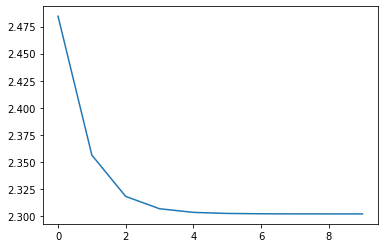

In [13]:
# let's look at the loss history!
plt.plot(loss_history)

In [14]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.082
Epoch 0, loss: 2.301880
Epoch 1, loss: 2.301869
Epoch 2, loss: 2.301865
Epoch 3, loss: 2.301857
Epoch 4, loss: 2.301859
Epoch 5, loss: 2.301884
Epoch 6, loss: 2.301865
Epoch 7, loss: 2.301863
Epoch 8, loss: 2.301884
Epoch 9, loss: 2.301863
Epoch 10, loss: 2.301852
Epoch 11, loss: 2.301859
Epoch 12, loss: 2.301846
Epoch 13, loss: 2.301862
Epoch 14, loss: 2.301862
Epoch 15, loss: 2.301889
Epoch 16, loss: 2.301865
Epoch 17, loss: 2.301863
Epoch 18, loss: 2.301874
Epoch 19, loss: 2.301865
Epoch 20, loss: 2.301849
Epoch 21, loss: 2.301864
Epoch 22, loss: 2.301849
Epoch 23, loss: 2.301870
Epoch 24, loss: 2.301869
Epoch 25, loss: 2.301857
Epoch 26, loss: 2.301877
Epoch 27, loss: 2.301867
Epoch 28, loss: 2.301849
Epoch 29, loss: 2.301854
Epoch 30, loss: 2.301862
Epoch 31, loss: 2.301862
Epoch 32, loss: 2.301853
Epoch 33, loss: 2.301877
Epoch 34, loss: 2.301866
Epoch 35, loss: 2.301865
Epoch 36, loss: 2.301858
Epoch 37, loss: 2.301851
Epoch 38, loss: 2.301872
Epoch 39, loss: 2.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [31]:
num_epochs = 500
batch_s = 50

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
reg_strengths = [0]#, 1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = None

# TODO use validation set to find the best hyperparameters

for l in learning_rates:
    for r in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        loss_history = classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=l, batch_size=batch_s, reg=r)
        #print(loss_history)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        print("Accuracy after training for", num_epochs, "epochs: ", "learning_rate:", l, "reg_strengths", r, "--", accuracy)
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

#print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 2.283578
Epoch 1, loss: 2.221806
Epoch 2, loss: 2.194549
Epoch 3, loss: 2.182822
Epoch 4, loss: 2.177756
Epoch 5, loss: 2.159567
Epoch 6, loss: 2.150808
Epoch 7, loss: 2.153043
Epoch 8, loss: 2.138009
Epoch 9, loss: 2.139993
Epoch 10, loss: 2.134289
Epoch 11, loss: 2.132416
Epoch 12, loss: 2.124453
Epoch 13, loss: 2.123696
Epoch 14, loss: 2.119438
Epoch 15, loss: 2.113664
Epoch 16, loss: 2.108598
Epoch 17, loss: 2.104463
Epoch 18, loss: 2.108194
Epoch 19, loss: 2.109901
Epoch 20, loss: 2.098200
Epoch 21, loss: 2.099888
Epoch 22, loss: 2.097741
Epoch 23, loss: 2.091419
Epoch 24, loss: 2.093511
Epoch 25, loss: 2.088126
Epoch 26, loss: 2.092232
Epoch 27, loss: 2.081719
Epoch 28, loss: 2.080612
Epoch 29, loss: 2.082214
Epoch 30, loss: 2.077747
Epoch 31, loss: 2.076864
Epoch 32, loss: 2.071582
Epoch 33, loss: 2.073660
Epoch 34, loss: 2.071093
Epoch 35, loss: 2.069950
Epoch 36, loss: 2.062306
Epoch 37, loss: 2.066627
Epoch 38, loss: 2.064298
Epoch 39, loss: 2.063497
Epoch 40, 

Epoch 320, loss: 1.899267
Epoch 321, loss: 1.898149
Epoch 322, loss: 1.898164
Epoch 323, loss: 1.896974
Epoch 324, loss: 1.897144
Epoch 325, loss: 1.896613
Epoch 326, loss: 1.901186
Epoch 327, loss: 1.896741
Epoch 328, loss: 1.895708
Epoch 329, loss: 1.902979
Epoch 330, loss: 1.900421
Epoch 331, loss: 1.896843
Epoch 332, loss: 1.892637
Epoch 333, loss: 1.898334
Epoch 334, loss: 1.892402
Epoch 335, loss: 1.898968
Epoch 336, loss: 1.893153
Epoch 337, loss: 1.887251
Epoch 338, loss: 1.893578
Epoch 339, loss: 1.894524
Epoch 340, loss: 1.892397
Epoch 341, loss: 1.885572
Epoch 342, loss: 1.887040
Epoch 343, loss: 1.893363
Epoch 344, loss: 1.891986
Epoch 345, loss: 1.896653
Epoch 346, loss: 1.892610
Epoch 347, loss: 1.891520
Epoch 348, loss: 1.887368
Epoch 349, loss: 1.885283
Epoch 350, loss: 1.889748
Epoch 351, loss: 1.889052
Epoch 352, loss: 1.879161
Epoch 353, loss: 1.893976
Epoch 354, loss: 1.887834
Epoch 355, loss: 1.883948
Epoch 356, loss: 1.884651
Epoch 357, loss: 1.890297
Epoch 358, l

Epoch 137, loss: 2.046205
Epoch 138, loss: 2.046108
Epoch 139, loss: 2.044954
Epoch 140, loss: 2.044868
Epoch 141, loss: 2.045413
Epoch 142, loss: 2.044972
Epoch 143, loss: 2.043963
Epoch 144, loss: 2.043349
Epoch 145, loss: 2.043622
Epoch 146, loss: 2.043620
Epoch 147, loss: 2.042905
Epoch 148, loss: 2.041811
Epoch 149, loss: 2.042152
Epoch 150, loss: 2.041556
Epoch 151, loss: 2.041159
Epoch 152, loss: 2.041378
Epoch 153, loss: 2.039880
Epoch 154, loss: 2.039658
Epoch 155, loss: 2.040860
Epoch 156, loss: 2.039596
Epoch 157, loss: 2.039733
Epoch 158, loss: 2.039177
Epoch 159, loss: 2.039146
Epoch 160, loss: 2.039072
Epoch 161, loss: 2.038027
Epoch 162, loss: 2.037905
Epoch 163, loss: 2.037750
Epoch 164, loss: 2.037485
Epoch 165, loss: 2.037330
Epoch 166, loss: 2.036413
Epoch 167, loss: 2.036964
Epoch 168, loss: 2.035481
Epoch 169, loss: 2.035791
Epoch 170, loss: 2.035921
Epoch 171, loss: 2.035548
Epoch 172, loss: 2.035549
Epoch 173, loss: 2.034412
Epoch 174, loss: 2.034156
Epoch 175, l

Epoch 453, loss: 1.980172
Epoch 454, loss: 1.979994
Epoch 455, loss: 1.979265
Epoch 456, loss: 1.979293
Epoch 457, loss: 1.980333
Epoch 458, loss: 1.979140
Epoch 459, loss: 1.979571
Epoch 460, loss: 1.978964
Epoch 461, loss: 1.979454
Epoch 462, loss: 1.978890
Epoch 463, loss: 1.978906
Epoch 464, loss: 1.979208
Epoch 465, loss: 1.979150
Epoch 466, loss: 1.978343
Epoch 467, loss: 1.978215
Epoch 468, loss: 1.977638
Epoch 469, loss: 1.978320
Epoch 470, loss: 1.978138
Epoch 471, loss: 1.977146
Epoch 472, loss: 1.977627
Epoch 473, loss: 1.977057
Epoch 474, loss: 1.977656
Epoch 475, loss: 1.977003
Epoch 476, loss: 1.977227
Epoch 477, loss: 1.976574
Epoch 478, loss: 1.976850
Epoch 479, loss: 1.976552
Epoch 480, loss: 1.976928
Epoch 481, loss: 1.976363
Epoch 482, loss: 1.976266
Epoch 483, loss: 1.976681
Epoch 484, loss: 1.975733
Epoch 485, loss: 1.975156
Epoch 486, loss: 1.975976
Epoch 487, loss: 1.974904
Epoch 488, loss: 1.975335
Epoch 489, loss: 1.975405
Epoch 490, loss: 1.974995
Epoch 491, l

Epoch 270, loss: 2.107659
Epoch 271, loss: 2.107572
Epoch 272, loss: 2.107343
Epoch 273, loss: 2.107340
Epoch 274, loss: 2.107154
Epoch 275, loss: 2.106971
Epoch 276, loss: 2.106803
Epoch 277, loss: 2.106661
Epoch 278, loss: 2.106484
Epoch 279, loss: 2.106436
Epoch 280, loss: 2.106290
Epoch 281, loss: 2.106106
Epoch 282, loss: 2.106016
Epoch 283, loss: 2.105820
Epoch 284, loss: 2.105746
Epoch 285, loss: 2.105582
Epoch 286, loss: 2.105488
Epoch 287, loss: 2.105236
Epoch 288, loss: 2.105163
Epoch 289, loss: 2.104996
Epoch 290, loss: 2.104878
Epoch 291, loss: 2.104739
Epoch 292, loss: 2.104622
Epoch 293, loss: 2.104541
Epoch 294, loss: 2.104398
Epoch 295, loss: 2.104189
Epoch 296, loss: 2.104103
Epoch 297, loss: 2.103935
Epoch 298, loss: 2.103817
Epoch 299, loss: 2.103680
Epoch 300, loss: 2.103513
Epoch 301, loss: 2.103365
Epoch 302, loss: 2.103280
Epoch 303, loss: 2.103178
Epoch 304, loss: 2.103053
Epoch 305, loss: 2.102921
Epoch 306, loss: 2.102727
Epoch 307, loss: 2.102679
Epoch 308, l

Epoch 86, loss: 2.263126
Epoch 87, loss: 2.262756
Epoch 88, loss: 2.262385
Epoch 89, loss: 2.262019
Epoch 90, loss: 2.261654
Epoch 91, loss: 2.261285
Epoch 92, loss: 2.260924
Epoch 93, loss: 2.260559
Epoch 94, loss: 2.260197
Epoch 95, loss: 2.259839
Epoch 96, loss: 2.259487
Epoch 97, loss: 2.259124
Epoch 98, loss: 2.258770
Epoch 99, loss: 2.258418
Epoch 100, loss: 2.258066
Epoch 101, loss: 2.257717
Epoch 102, loss: 2.257361
Epoch 103, loss: 2.257013
Epoch 104, loss: 2.256664
Epoch 105, loss: 2.256322
Epoch 106, loss: 2.255975
Epoch 107, loss: 2.255635
Epoch 108, loss: 2.255289
Epoch 109, loss: 2.254950
Epoch 110, loss: 2.254610
Epoch 111, loss: 2.254273
Epoch 112, loss: 2.253933
Epoch 113, loss: 2.253597
Epoch 114, loss: 2.253261
Epoch 115, loss: 2.252934
Epoch 116, loss: 2.252603
Epoch 117, loss: 2.252267
Epoch 118, loss: 2.251932
Epoch 119, loss: 2.251607
Epoch 120, loss: 2.251278
Epoch 121, loss: 2.250955
Epoch 122, loss: 2.250628
Epoch 123, loss: 2.250301
Epoch 124, loss: 2.249983


Epoch 402, loss: 2.191596
Epoch 403, loss: 2.191457
Epoch 404, loss: 2.191323
Epoch 405, loss: 2.191194
Epoch 406, loss: 2.191061
Epoch 407, loss: 2.190929
Epoch 408, loss: 2.190795
Epoch 409, loss: 2.190671
Epoch 410, loss: 2.190537
Epoch 411, loss: 2.190406
Epoch 412, loss: 2.190281
Epoch 413, loss: 2.190151
Epoch 414, loss: 2.190024
Epoch 415, loss: 2.189897
Epoch 416, loss: 2.189768
Epoch 417, loss: 2.189636
Epoch 418, loss: 2.189507
Epoch 419, loss: 2.189383
Epoch 420, loss: 2.189257
Epoch 421, loss: 2.189131
Epoch 422, loss: 2.189006
Epoch 423, loss: 2.188878
Epoch 424, loss: 2.188749
Epoch 425, loss: 2.188628
Epoch 426, loss: 2.188507
Epoch 427, loss: 2.188377
Epoch 428, loss: 2.188254
Epoch 429, loss: 2.188128
Epoch 430, loss: 2.188008
Epoch 431, loss: 2.187886
Epoch 432, loss: 2.187760
Epoch 433, loss: 2.187640
Epoch 434, loss: 2.187518
Epoch 435, loss: 2.187395
Epoch 436, loss: 2.187270
Epoch 437, loss: 2.187149
Epoch 438, loss: 2.187028
Epoch 439, loss: 2.186908
Epoch 440, l

Epoch 218, loss: 2.290685
Epoch 219, loss: 2.290636
Epoch 220, loss: 2.290587
Epoch 221, loss: 2.290538
Epoch 222, loss: 2.290489
Epoch 223, loss: 2.290440
Epoch 224, loss: 2.290391
Epoch 225, loss: 2.290342
Epoch 226, loss: 2.290293
Epoch 227, loss: 2.290244
Epoch 228, loss: 2.290195
Epoch 229, loss: 2.290146
Epoch 230, loss: 2.290097
Epoch 231, loss: 2.290048
Epoch 232, loss: 2.289999
Epoch 233, loss: 2.289951
Epoch 234, loss: 2.289901
Epoch 235, loss: 2.289853
Epoch 236, loss: 2.289803
Epoch 237, loss: 2.289755
Epoch 238, loss: 2.289707
Epoch 239, loss: 2.289657
Epoch 240, loss: 2.289609
Epoch 241, loss: 2.289561
Epoch 242, loss: 2.289512
Epoch 243, loss: 2.289463
Epoch 244, loss: 2.289415
Epoch 245, loss: 2.289366
Epoch 246, loss: 2.289317
Epoch 247, loss: 2.289269
Epoch 248, loss: 2.289221
Epoch 249, loss: 2.289172
Epoch 250, loss: 2.289123
Epoch 251, loss: 2.289075
Epoch 252, loss: 2.289026
Epoch 253, loss: 2.288978
Epoch 254, loss: 2.288930
Epoch 255, loss: 2.288881
Epoch 256, l

# Какой же точности мы добились на тестовых данных?

In [38]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

NameError: name 'best_classifier' is not defined